# Preliminaries

In [1]:
from __future__ import division, print_function
from functools import partial
import gpflow
import tensorflow as tf
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from scipy import signal, linalg

# Nice progress bars
try:
    from tqdm import tqdm
except ImportError:
    tqdm = lambda x: x

import safe_learning
import plotting
from utilities import InvertedPendulum
from utilities import SpringDamper

%matplotlib inline
# Open a new session (close old one if exists)
try:
    session.close()
except NameError:
    pass
session = tf.InteractiveSession()
session.run(tf.global_variables_initializer())

/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


# The dynamic system
Here we examine the cases where the system dynamics are described by a set of linear differential equations and the cost is described by a quadratic function. 
The LQR controller is described by

dot.x = Ax + Bu

# EXAMPLE 1: Mass-Spring-Damper System Dynamics
The 1st order ODE:

The 2nd order ODE:
x¨ + cx˙ + kx = F

k: stiffness of the spring (N/m)

c: damping coefficient (kg · m/s2)

m: mass of the block (kg)

F: external force (N)

(1)Wrong model

In [2]:
mm = 0.1
wrong_c = 0.0
wrong_mass = 0.5
wrong_k = 100
wrong_inertia = 0.1 * wrong_mass ** 2

In [3]:
n = 2
m = 1

(2)True model

In [4]:
true_m = 0.15
true_c = 0.1
true_mass = wrong_mass
true_k = wrong_k
true_inertia = 0.15 * wrong_mass ** 2

Set up the boundaries for the states and actions

In [5]:
# Input saturation
x_max = np.deg2rad(30)
u_max = wrong_k * true_m * true_mass * np.sin(x_max)

In [6]:
print(x_max)
print(u_max)

0.5235987755982988
3.7499999999999996


Normalization

In [7]:
norm_state = np.array([x_max, np.sqrt(wrong_k /wrong_mass)])
norm_action = np.array([u_max])

Corresponding dynamic systems

In [8]:
true_dynamics = InvertedPendulum(mass=true_m, length=true_mass, friction=true_c,
                                 normalization=(norm_state, norm_action))

wrong_dynamics = InvertedPendulum(mass=mm, length=wrong_mass, friction=wrong_c,
                                  normalization=(norm_state, norm_action))

In [9]:
#true_dynamics = SpringDamper(m=true_m, mass=true_mass, c=true_c,
                               #  normalization=(norm_state, norm_action))

#wrong_dynamics = SpringDamper#    normalization=(norm_state, norm_action))

# LQR and reward function

In [10]:
# LQR cost matrices
q = 1 * np.diag([1., 2.])
r = 1.2 * np.array([[1]], dtype=safe_learning.config.np_dtype)

# Quadratic (LQR) reward function
gamma = 0.98
reward_function = safe_learning.QuadraticFunction(linalg.block_diag(-q, -r))

# Set up a discretization for safety verification

In [11]:
# x_min, x_max, discretization\
state_limits = np.array([[-2., 2.], [-1.5, 1.5]])
action_limits = np.array([[-1, 1]])
num_states = [2001, 1501]

safety_disc = safe_learning.GridWorld(state_limits, num_states)
policy_disc = safe_learning.GridWorld(state_limits, [55, 55])

# Discretization constant
tau = np.min(safety_disc.unit_maxes)

print('Grid size: {0}'.format(safety_disc.nindex))

Grid size: 3003501


# Define the GP dynamics model

We use a combination of kernels to model the errors in the dynamics

In [12]:
A, B = wrong_dynamics.linearize()
lipschitz_dynamics = 1

noise_var = 0.001 ** 2

m_true = np.hstack((true_dynamics.linearize()))
m = np.hstack((A, B))

variances = (m_true - m) ** 2

# Make sure things remain 
np.clip(variances, 1e-5, None, out=variances)

# Kernels
kernel1 = (gpflow.kernels.Linear(3, variance=variances[0, :], ARD=True)
           + gpflow.kernels.Matern32(1, lengthscales=1, active_dims=[0])
           * gpflow.kernels.Linear(1, variance=variances[0, 1]))

kernel2 = (gpflow.kernels.Linear(3, variance=variances[1, :], ARD=True)
           + gpflow.kernels.Matern32(1, lengthscales=1, active_dims=[0])
           * gpflow.kernels.Linear(1, variance=variances[1, 1]))

# Mean dynamics

mean_dynamics = safe_learning.LinearSystem((A, B), name='mean_dynamics')
mean_function1 = safe_learning.LinearSystem((A[[0], :], B[[0], :]), name='mean_dynamics_1')
mean_function2 = safe_learning.LinearSystem((A[[1], :], B[[1], :]), name='mean_dynamics_2')

# Define a GP model over the dynamics
gp1 = gpflow.gpr.GPR(np.empty((0, 3), dtype=safe_learning.config.np_dtype),
                    np.empty((0, 1), dtype=safe_learning.config.np_dtype),
                    kernel1,
                    mean_function=mean_function1)
gp1.likelihood.variance = noise_var

gp2 = gpflow.gpr.GPR(np.empty((0, 3), dtype=safe_learning.config.np_dtype),
                    np.empty((0, 1), dtype=safe_learning.config.np_dtype),
                    kernel2,
                    mean_function=mean_function2)
gp2.likelihood.variance = noise_var

gp1_fun = safe_learning.GaussianProcess(gp1)
gp2_fun = safe_learning.GaussianProcess(gp2)

dynamics = safe_learning.FunctionStack((gp1_fun, gp2_fun))

In [13]:
# Compute the optimal policy for the linear (and wrong) mean dynamics
k, s = safe_learning.utilities.dlqr(A, B, q, r)
init_policy = safe_learning.LinearSystem((-k), name='initial_policy')
init_policy = safe_learning.Saturation(init_policy, -1, 1)

# Define the Lyapunov function corresponding to the initial policy
init_lyapunov = safe_learning.QuadraticFunction(s)

# Set up the dynamic programming problem

In [14]:
# Define a neural network policy
relu = tf.nn.relu
policy = safe_learning.NeuralNetwork(layers=[32, 32, 1],
                                     nonlinearities=[relu, relu, tf.nn.tanh],
                                     scaling=action_limits[0, 1])

# Define value function approximation
value_function = safe_learning.Triangulation(policy_disc,
                                             -init_lyapunov(policy_disc.all_points).eval(),
                                             project=True)

# Define policy optimization problem
rl = safe_learning.PolicyIteration(
    policy,
    dynamics,
    reward_function,
    value_function,
    gamma=gamma)
    

with tf.name_scope('rl_mean_optimization'):
    rl_opt_value_function = rl.optimize_value_function()
    
    # Placeholder for states
    tf_states_mean = tf.placeholder(safe_learning.config.dtype, [None, 2])
    
    # Optimize for expected gain
    values = rl.future_values(tf_states_mean)
    policy_loss = -tf.reduce_mean(values)
    
    optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.1)
    adapt_policy_mean = optimizer.minimize(policy_loss, var_list=rl.policy.parameters)


Instructions for updating:
keep_dims is deprecated, use keepdims instead


/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:100: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


In [15]:
# Start the session
session.run(tf.global_variables_initializer())

### Run initial dynamic programming for the mean dynamics

In [16]:
for i in tqdm(range(3000)):
    
    # select random training batches
    rl.feed_dict[tf_states_mean] = policy_disc.sample_continuous(1000)

    session.run(adapt_policy_mean, feed_dict=rl.feed_dict)

# Define the Lyapunov function

Here we use the fact that the optimal value function is a Lyapunov function for the optimal policy if the dynamics are deterministic. As uncertainty about the dynamics decreases, the value function for the mean dynamics will thus converge to a Lyapunov function.

In [17]:
lyapunov_function = -rl.value_function
lipschitz_lyapunov = lambda x: tf.reduce_max(tf.abs(rl.value_function.gradient(x)),
                                             axis=1, keep_dims=True)

lipschitz_policy = lambda x: policy.lipschitz() 

a_true, b_true = true_dynamics.linearize()
lipschitz_dynamics = lambda x: np.max(np.abs(a_true)) + np.max(np.abs(b_true)) * lipschitz_policy(x)

# Lyapunov function definitial
lyapunov = safe_learning.Lyapunov(safety_disc,
                                  lyapunov_function,
                                  dynamics,
                                  lipschitz_dynamics,
                                  lipschitz_lyapunov,
                                  tau,
                                  policy=rl.policy,
                                  initial_set=None)

# Set initial safe set (level set) based on initial Lyapunov candidate
values = init_lyapunov(safety_disc.all_points).eval()
cutoff = np.max(values) * 0.005

lyapunov.initial_safe_set = np.squeeze(values, axis=1) <= cutoff

Instructions for updating:
keep_dims is deprecated, use keepdims instead


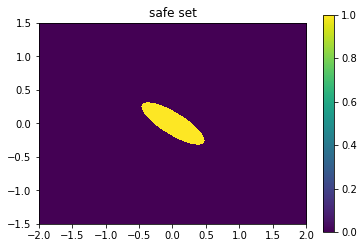

In [18]:
def plot_safe_set(lyapunov, show=True):
    """Plot the safe set for a given Lyapunov function."""
    plt.imshow(lyapunov.safe_set.reshape(num_states).T,
               origin='lower',
               extent=lyapunov.discretization.limits.ravel(),
               vmin=0,
               vmax=1)
    
    if isinstance(lyapunov.dynamics, safe_learning.UncertainFunction):
        X = lyapunov.dynamics.functions[0].X
        plt.plot(X[:, 0], X[:, 1], 'rx')
    
    plt.title('safe set')
    plt.colorbar()
    if show:
        plt.show()
    
lyapunov.update_safe_set()
plot_safe_set(lyapunov)

## Safe policy update

We do dynamic programming, but enfore the decrease condition on the Lyapunov function using a Lagrange multiplier

In [19]:
with tf.name_scope('policy_optimization'):
    
    # Placeholder for states
    tf_states = tf.placeholder(safe_learning.config.dtype, [None, 2])
    
    # Add Lyapunov uncertainty (but only if safety-relevant)
    values = rl.future_values(tf_states, lyapunov=lyapunov)
    
    policy_loss = -tf.reduce_mean(values)
    

    optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.01)
    adapt_policy = optimizer.minimize(policy_loss, var_list=rl.policy.parameters)
    
    
def rl_optimize_policy(num_iter):
    # Optimize value function
    session.run(rl_opt_value_function, feed_dict=rl.feed_dict)

    # select random training batches
    for i in tqdm(range(num_iter)):
        rl.feed_dict[tf_states] = lyapunov.discretization.sample_continuous(1000)

        session.run(adapt_policy, feed_dict=rl.feed_dict)

/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:100: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


# Exploration

We explore close to the current policy by sampling the most uncertain state that does not leave the current level set

In [20]:
action_variation = np.array([[-0.02], [0.], [0.02]], dtype=safe_learning.config.np_dtype)


with tf.name_scope('add_new_measurement'):
        action_dim = lyapunov.policy.output_dim
        tf_max_state_action = tf.placeholder(safe_learning.config.dtype,
                                             shape=[1, safety_disc.ndim + action_dim])
        tf_measurement = true_dynamics(tf_max_state_action)
        
def update_gp():
    """Update the GP model based on an actively selected data point."""
    # Get a new sample location
    max_state_action, _ = safe_learning.get_safe_sample(lyapunov,
                                                        action_variation,
                                                        action_limits,
                                                        num_samples=1000)

    # Obtain a measurement of the true dynamics
    lyapunov.feed_dict[tf_max_state_action] = max_state_action
    measurement = tf_measurement.eval(feed_dict=lyapunov.feed_dict)

    # Add the measurement to our GP dynamics
    lyapunov.dynamics.add_data_point(max_state_action, measurement)
    

# Run the optimization

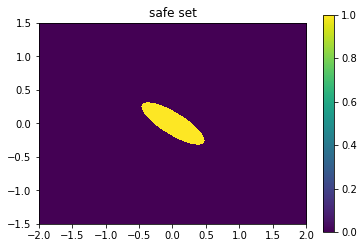

In [21]:
# lyapunov.update_safe_set()
rl_optimize_policy(num_iter=100)
rl_optimize_policy(num_iter=100)

lyapunov.update_safe_set()
plot_safe_set(lyapunov)

iteration 0 with c_max: 1.1562307196200226


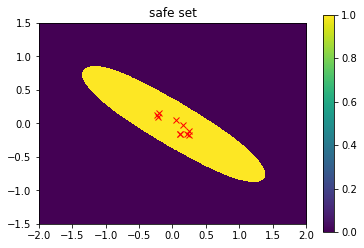

iteration 1 with c_max: 10.480698889137566


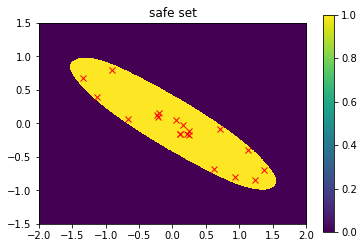

iteration 2 with c_max: 12.828828501126175


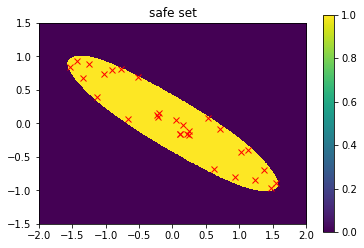

iteration 3 with c_max: 13.353225358758058


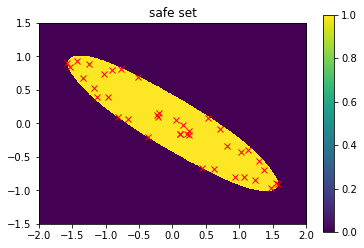

iteration 4 with c_max: 13.485477715239892


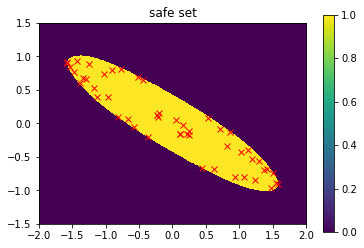

In [22]:
for i in range(5):
    print('iteration {} with c_max: {}'.format(i, lyapunov.feed_dict[lyapunov.c_max]))
    for i in tqdm(range(10)):
        update_gp()
    
    rl_optimize_policy(num_iter=100)
    lyapunov.update_values()
    
    # Update safe set and plot
    lyapunov.update_safe_set()
    plot_safe_set(lyapunov)    

# Plot trajectories and analyse improvement

In [23]:
x0 = np.array([[1., -.5]])

states_new, actions_new = safe_learning.utilities.compute_trajectory(true_dynamics, rl.policy, x0, 100)
states_old, actions_old = safe_learning.utilities.compute_trajectory(true_dynamics, init_policy, x0, 100)

t = np.arange(len(states_new)) * true_dynamics.dt

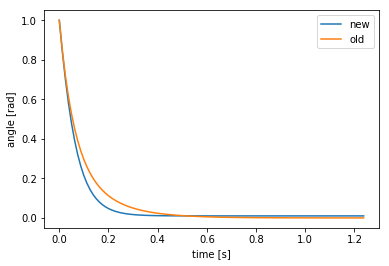

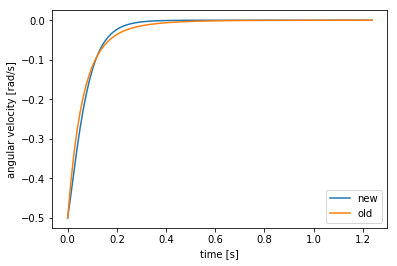

In [24]:
plt.plot(t, states_new[:, 0], label='new')
plt.plot(t, states_old[:, 0], label='old')
plt.xlabel('time [s]')
plt.ylabel('angle [rad]')
plt.legend()
plt.show()

plt.plot(t, states_new[:, 1], label='new')
plt.plot(t, states_old[:, 1], label='old')
plt.xlabel('time [s]')
plt.ylabel('angular velocity [rad/s]')
plt.legend()
plt.show()

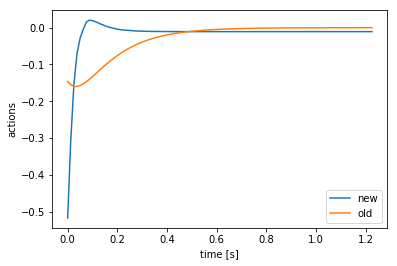

In [25]:
plt.plot(t[:-1], actions_new, label='new')
plt.plot(t[:-1], actions_old, label='old')
plt.xlabel('time [s]')
plt.ylabel('actions')
plt.legend()

In [26]:
print('reward old:', tf.reduce_sum(rl.reward_function(states_old[:-1], actions_old)).eval(feed_dict=rl.feed_dict))
print('reward new:', tf.reduce_sum(rl.reward_function(states_new[:-1], actions_new)).eval(feed_dict=rl.feed_dict))

reward old: -5.748512721023727
reward new: -5.586149989343252


In [27]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
%matplotlib inline

import safe_learning
import plotting

In [28]:
# Define the reinforcement learning setup

# Create a tensorflow session
session = tf.InteractiveSession()
session.run(tf.global_variables_initializer())

# Optimize over policy variables
with tf.name_scope('dynamics_programming'):
    # For triangulations we can solve a linear programm to determine the value function
    # value_opt = rl.value_iteration()
    value_opt = rl.optimize_value_function()
    
    # The policy is optimized using gradient descent
    policy_loss = -1 / (1-gamma) * tf.reduce_mean(rl.future_values(rl.state_space))

    optimizer = tf.train.GradientDescentOptimizer(1.)
    adapt_policy = optimizer.minimize(policy_loss,
                                      var_list=[rl.policy.parameters])


/anaconda3/lib/python3.6/site-packages/tensorflow/python/client/session.py:1711: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


In [30]:
plotting.show_graph(tf.get_default_graph())

In [29]:

old_values = np.zeros_like(rl.value_function.parameters[0].eval())
old_actions = np.zeros_like(rl.policy.parameters[0].eval())
converged = False
action_space = np.array([[-1.], [1.]])


for i in range(30):
    # Optimize value function
    value_opt.eval()

    # Optimize policy (discrete over grid or gradient descent)
    # rl.discrete_policy_optimization(action_space)
    for _ in range(200):
        session.run(adapt_policy)

    # Get new parameters
    values, actions = session.run([rl.value_function.parameters[0],
                                  rl.policy.parameters[0]])

    # Compute errors
    value_change = np.max(np.abs(old_values - values))
    actions_change = np.max(np.abs(old_actions - actions))

    # Break if converged
    if value_change <= 1e-1 and actions_change <= 1e-1:
        converged = True
        break
    else:
        old_values = values
        old_actions = actions


if converged:
    print('converged after {} iterations. \nerror: {}, \npolicy: {}'
          .format(i + 1, value_change, actions_change))
else:
    print('didnt converge, error: {} and policy: {}'
          .format(value_change, actions_change))

InvalidArgumentError: You must feed a value for placeholder tensor 'gaussian_process/Placeholder' with dtype double and shape [?]
	 [[Node: gaussian_process/Placeholder = Placeholder[dtype=DT_DOUBLE, shape=[?], _device="/job:localhost/replica:0/task:0/device:CPU:0"]()]]

Caused by op 'gaussian_process/Placeholder', defined at:
  File "/anaconda3/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/anaconda3/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/anaconda3/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/anaconda3/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 478, in start
    self.io_loop.start()
  File "/anaconda3/lib/python3.6/site-packages/zmq/eventloop/ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "/anaconda3/lib/python3.6/site-packages/tornado/ioloop.py", line 888, in start
    handler_func(fd_obj, events)
  File "/anaconda3/lib/python3.6/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/anaconda3/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "/anaconda3/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "/anaconda3/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/anaconda3/lib/python3.6/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/anaconda3/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/anaconda3/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 233, in dispatch_shell
    handler(stream, idents, msg)
  File "/anaconda3/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "/anaconda3/lib/python3.6/site-packages/ipykernel/ipkernel.py", line 208, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/anaconda3/lib/python3.6/site-packages/ipykernel/zmqshell.py", line 537, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2728, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2850, in run_ast_nodes
    if self.run_code(code, result):
  File "/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2910, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-12-09df862003f0>", line 42, in <module>
    gp1_fun = safe_learning.GaussianProcess(gp1)
  File "/anaconda3/lib/python3.6/site-packages/safe_learning/functions.py", line 461, in __init__
    self.hyperparameters = [tf.placeholder(config.dtype, [None])]
  File "/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/array_ops.py", line 1808, in placeholder
    return gen_array_ops.placeholder(dtype=dtype, shape=shape, name=name)
  File "/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/gen_array_ops.py", line 4848, in placeholder
    "Placeholder", dtype=dtype, shape=shape, name=name)
  File "/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 3392, in create_op
    op_def=op_def)
  File "/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 1718, in __init__
    self._traceback = self._graph._extract_stack()  # pylint: disable=protected-access

InvalidArgumentError (see above for traceback): You must feed a value for placeholder tensor 'gaussian_process/Placeholder' with dtype double and shape [?]
	 [[Node: gaussian_process/Placeholder = Placeholder[dtype=DT_DOUBLE, shape=[?], _device="/job:localhost/replica:0/task:0/device:CPU:0"]()]]


In [ ]:
plotting.plot_triangulation(rl.value_function, xlabel='position', ylabel='velocity')
plt.show()

plotting.plot_triangulation(rl.value_function, three_dimensional=True,
                            xlabel='position', ylabel='velocity', zlabel='values')
plt.show()

In [ ]:
plotting.plot_triangulation(rl.policy, zlabel='policy', xlabel='position', ylabel='velocity')
plt.show()

In [ ]:
with tf.name_scope('compute_trajectory333'):
    states = np.zeros((1000, 2), dtype=np.float)
    states[0, 0] = -0.5

    state = tf.placeholder(tf.float64, [1, 2])
    next_states = rl.dynamics(state, rl.policy(state))

In [ ]:
states

In [ ]:
next_states[0]

In [ ]:
# Compute the trajectories.
for i in range(len(states) - 1):
    states[i+1, :] = next_states[0].eval(feed_dict={state: states[[i], :]})

    # break if terminal
    if states[i+1, 0] >= 0.6:
        states[i+1:] = states[i+1]
        break

In [ ]:
ax = plotting.plot_triangulation(rl.value_function, xlabel='position', ylabel='velocity')
ax.plot(states_new[:,0], states_new[:, 1], lw=3, color='k')
#ax.plot(np.ones(2) * 0.6, ax.get_ylim(), lw=2, color='r')

plt.show()

In [ ]:
import tkinter
import math
from tkinter import *
import time

In [ ]:
def rotate(points, angle, center):
    angle = math.radians(angle)
    cos_val = math.cos(angle)
    sin_val = math.sin(angle)
    cx, cy = center
    new_points = []
    for x_old, y_old in points:
        x_old -= cx
        y_old -= cy
        x_new = x_old * cos_val - y_old * sin_val
        y_new = x_old * sin_val + y_old * cos_val
        new_points.append([x_new + cx, y_new + cy])
    return new_points
def draw_square(points, fill="yellow"):
    w.create_rectangle(points, fill="yellow")

In [ ]:
#实例化
tk = tkinter.Tk()
tk.title('inverted pendulum')

w = Canvas(tk, width=200, height=200)
w.pack()
w.create_rectangle(50, 80, 150, 100, fill="black")
w.create_oval(65,100,85,120)
w.create_oval(115,100,135,120)
id = w.create_rectangle(99,30,101,80, fill = "yellow")

WIDTH = 2
HEIGHT = 50
CANVAS_MID_X = 100
CANVAS_MID_Y = 55

vertices = [
    [CANVAS_MID_X - WIDTH/2, CANVAS_MID_Y - HEIGHT/2],
    [CANVAS_MID_X + WIDTH/2, CANVAS_MID_Y - HEIGHT/2],
    [CANVAS_MID_X + WIDTH/2, CANVAS_MID_Y + HEIGHT/2],
    [CANVAS_MID_X - WIDTH/2, CANVAS_MID_Y + HEIGHT/2],
]

def rotate(points, angle, center):
    angle = math.radians(angle)
    cos_val = math.cos(angle)
    sin_val = math.sin(angle)
    cx, cy = center
    new_points = []
    for x_old, y_old in points:
        x_old -= cx
        y_old -= cy
        x_new = x_old * cos_val - y_old * sin_val
        y_new = x_old * sin_val + y_old * cos_val
        new_points.append([x_new + cx, y_new + cy])
    return new_points
def draw_square(points, fill ="yellow"):
    w.create_polygon(points, fill = "yellow")
center = (100,80)
new_rectangle = rotate(vertices, 30, center)
w.delete(id)
draw_square(new_rectangle)
mainloop()

In [ ]:
sleep_time =0.025

In [ ]:
#实例化
tk = tkinter.Tk()
tk.title('inverted pendulum')

w = Canvas(tk, width=200, height=200)
w.pack()
w.create_rectangle(50, 80, 150, 100, fill="black")
w.create_oval(65,100,85,120)
w.create_oval(115,100,135,120)
id = w.create_rectangle(99,30,101,80, fill = "yellow")

WIDTH = 2
HEIGHT = 50
CANVAS_MID_X = 100
CANVAS_MID_Y = 55

vertices = [
    [CANVAS_MID_X - WIDTH/2, CANVAS_MID_Y - HEIGHT/2],
    [CANVAS_MID_X + WIDTH/2, CANVAS_MID_Y - HEIGHT/2],
    [CANVAS_MID_X + WIDTH/2, CANVAS_MID_Y + HEIGHT/2],
    [CANVAS_MID_X - WIDTH/2, CANVAS_MID_Y + HEIGHT/2],
]

def rotate(points, angle, center):
    #angle = math.radians(angle)
    cos_val = math.cos(angle)
    sin_val = math.sin(angle)
    cx, cy = center
    new_points = []
    for x_old, y_old in points:
        x_old -= cx
        y_old -= cy
        x_new = x_old * cos_val - y_old * sin_val
        y_new = x_old * sin_val + y_old * cos_val
        new_points.append([x_new + cx, y_new + cy])
    return new_points
def draw_square(points, fill ="red"):
    id = w.create_rectangle(list(points), fill = "red")

center = (100,80)
for i in range(states_new.shape[0]):
    new_rectangle = rotate(vertices, states_new[i, 0], center)
    draw_square(new_rectangle)
    w.update()
    #暂停
    time.sleep(sleep_time)
    w.delete(id)
    
tk.mainloop()